In [1]:
import gc
import os
import random
from typing import List, Tuple

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_covtype
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import Binarizer, KBinsDiscretizer
from skopt import gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Integer
from tqdm.notebook import tqdm

In [4]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp

In [5]:
def find_best_rf(X: np.ndarray, y: np.ndarray) -> RandomForestClassifier:
    space = [
        Real(0.000001, 0.01, 'log-uniform', name='ccp_alpha'),
        Real(0.5, 0.85, 'uniform', name='max_features'),
        Real(0.6, 0.95, 'uniform', name='max_samples'),
        Integer(50, 1000, name='n_estimators')
    ]
    
    @use_named_args(space)
    def objective_f(ccp_alpha: float, max_features: float,
                    max_samples: float, n_estimators: int) -> float:
        test_cls = RandomForestClassifier(
            min_samples_leaf=5, n_estimators=n_estimators,
            random_state=42, verbose=True, n_jobs=-1,
            ccp_alpha=ccp_alpha, oob_score=True, bootstrap=True,
            max_samples=max_samples, max_features=max_features,
        )
        test_cls.fit(X, y)
        nd = len(test_cls.oob_decision_function_.shape)
        if nd != 2:
            err_msg = f'`oob_decision_function_` is wrong! ' \
                      f'Expected 2-D array, got {nd}-D one!'
            raise ValueError(err_msg)
        filtered = list(
            filter(
                lambda idx: not any(np.isnan(
                    test_cls.oob_decision_function_[idx]
                )),
                range(y.shape[0])
            )
        )
        info_msg = f'OOB score is estimated using {len(filtered)} ' \
                   f'samples from {y.shape[0]}.'
        print(info_msg)
        if len(filtered) < 3:
            err_msg = 'OOB score cannot be estimated!'
            raise ValueError(err_msg)
        quality = f1_score(
            y_true=y[filtered],
            y_pred=np.argmax(test_cls.oob_decision_function_[filtered],
                             axis=-1),
            average='macro'
        )
        return -quality
    
    res_gp = gp_minimize(
        objective_f, space,
        n_calls=32, n_random_starts=8,
        n_restarts_optimizer=4, random_state=42,
        verbose=True, n_jobs=1
    )
    best_parameters = {
        'ccp_alpha': float(res_gp.x[0]),
        'max_features': float(res_gp.x[1]),
        'max_samples': float(res_gp.x[2]),
        'n_estimators': int(res_gp.x[3]),
    }
    print(f'Best parameters are: {best_parameters}')
    final_cls = RandomForestClassifier(
        min_samples_leaf=5, random_state=42, verbose=True, n_jobs=-1,
        oob_score=True, bootstrap=True,
        ccp_alpha=best_parameters['ccp_alpha'],
        n_estimators=best_parameters['n_estimators'],
        max_samples=best_parameters['max_samples'],
        max_features=best_parameters['max_features'],
    )
    final_cls.fit(X, y)
    return final_cls

In [6]:
def build_normalizer(X: np.ndarray) -> Pipeline:
    normalizer = Pipeline(steps=[
        (
            'imputer',
            SimpleImputer(missing_values=np.nan, strategy='mean')
        ),
        (
            'standard_scaler',
            StandardScaler(with_mean=True, with_std=True)
        ),
        (
            'pca',
            PCA(random_state=42)
        )
    ])
    return normalizer.fit(X)

In [7]:
def generate_initializer():
    try:
        kernel_initializer = tf.keras.initializers.LecunNormal(
            seed=random.randint(0, 2147483647)
        )
    except:
        kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
            seed=random.randint(0, 2147483647)
        )
    return kernel_initializer

In [8]:
def build_neural_network(n_features: int, n_classes: int,
                         n_latent: int, n_hidden: int, depth: int,
                         nn_name: str) -> Tuple[tf.keras.Model, tf.keras.Model, \
                                                tf.keras.Model]:
    if n_hidden < 1:
        err_msg = f'The hidde layer size = {n_hidden} is too small!'
    feature_vector = tf.keras.layers.Input(
        shape=(n_features,), dtype=tf.float32,
        name=f'{nn_name}_feature_vector'
    )
    block_input = feature_vector
    for layer_idx in range(depth):
        first_layer = tf.keras.layers.Dense(
            units=n_hidden,
            activation='tanh',
            kernel_initializer=generate_initializer(),
            bias_initializer='zeros',
            name=f'{nn_name}_enc_dense{layer_idx * 3 + 1}'
        )(block_input)
        second_layer = tf.keras.layers.Dense(
            units=n_hidden,
            activation='tanh',
            kernel_initializer=generate_initializer(),
            bias_initializer='zeros',
            name=f'{nn_name}_enc_dense{layer_idx * 3 + 2}'
        )(first_layer)
        third_layer = tf.keras.layers.Dense(
            units=n_hidden,
            activation='tanh',
            kernel_initializer=generate_initializer(),
            bias_initializer='zeros',
            name=f'{nn_name}_enc_dense{layer_idx * 3 + 3}'
        )(second_layer)
        encoder_layer = tf.keras.layers.Add(
            name=f'{nn_name}_enc_add{layer_idx + 1}'
        )([first_layer, third_layer])
        block_input = encoder_layer
        del first_layer, second_layer, third_layer
    del block_input
    prior = tfp.distributions.Independent(
        distribution=tfp.distributions.Normal(
            loc=tf.zeros(n_latent),
            scale=1
        ),
        reinterpreted_batch_ndims=1
    )
    latent_layer = tf.keras.layers.Dense(
        units=tfp.layers.IndependentNormal.params_size(n_latent),
        activation=None,
        kernel_initializer=generate_initializer(),
        bias_initializer='zeros',
        name=f'{nn_name}_latent'
    )(encoder_layer)
    z = tfp.layers.IndependentNormal(
        event_shape=n_latent,
        convert_to_tensor_fn=tfp.distributions.Distribution.sample,
        activity_regularizer=tfp.layers.KLDivergenceRegularizer(
            distribution_b=prior,
            weight=1e-3
        ),
        name=f'{nn_name}_z'
    )(latent_layer)
    classifier_input = tf.keras.layers.Input(
        shape=(n_latent,), dtype=tf.float32,
        name=f'{nn_name}_feature_vector'
    )
    hidden_layer = tf.keras.layers.Dense(
        units=n_hidden,
        activation='tanh',
        kernel_initializer=generate_initializer(),
        bias_initializer='zeros',
        name=f'{nn_name}_cls_hidden'
    )(classifier_input)
    cls_layer = tf.keras.layers.Dense(
        units=n_classes,
        activation='softmax',
        kernel_initializer=generate_initializer(),
        bias_initializer='zeros',
        name=f'{nn_name}_cls_output'
    )(hidden_layer)
    cls_name = f'{nn_name}_cls'
    cls_model = tf.keras.Model(
        inputs=classifier_input,
        outputs=cls_layer,
        name=cls_name
    )
    cls_model.build(input_shape=[None, n_latent])
    block_input = z
    for layer_idx in range(depth):
        first_layer = tf.keras.layers.Dense(
            units=n_hidden,
            activation='tanh',
            kernel_initializer=generate_initializer(),
            bias_initializer='zeros',
            name=f'{nn_name}_dec_dense{layer_idx * 3 + 1}'
        )(block_input)
        second_layer = tf.keras.layers.Dense(
            units=n_hidden,
            activation='tanh',
            kernel_initializer=generate_initializer(),
            bias_initializer='zeros',
            name=f'{nn_name}_dec_dense{layer_idx * 3 + 2}'
        )(first_layer)
        third_layer = tf.keras.layers.Dense(
            units=n_hidden,
            activation='tanh',
            kernel_initializer=generate_initializer(),
            bias_initializer='zeros',
            name=f'{nn_name}_dec_dense{layer_idx * 3 + 3}'
        )(second_layer)
        decoder_layer = tf.keras.layers.Add(
            name=f'{nn_name}_dec_add{layer_idx + 1}'
        )([first_layer, third_layer])
        block_input = decoder_layer
        del first_layer, second_layer, third_layer
    reconstruction_name =   f'{nn_name}_reconstruction'
    reconstruction_layer = tf.keras.layers.Dense(
        units=n_features,
        activation=None,
        kernel_initializer=generate_initializer(),
        bias_initializer='zeros',
        name=reconstruction_name
    )(decoder_layer)
    encoder_model = tf.keras.Model(
        inputs=feature_vector,
        outputs=z,
        name=f'{nn_name}_enc'
    )
    united_model = tf.keras.Model(
        inputs=feature_vector,
        outputs=[cls_model(z), reconstruction_layer],
        name=f'{nn_name}_vae'
    )
    encoder_model.build(input_shape=[None, n_features])
    metrics = {cls_name: [tf.keras.metrics.CategoricalAccuracy()]}
    negloglik = lambda y, rv_y: -rv_y.log_prob(y)
    losses = {
        cls_name: tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        reconstruction_name: tf.keras.losses.LogCosh()
    }
    loss_weights = {
        cls_name: 1.0,
        reconstruction_name: 1.5
    }
    radam = tfa.optimizers.RectifiedAdam(learning_rate=1e-3)
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
    united_model.compile(optimizer=ranger, loss=losses,
                         loss_weights=loss_weights, metrics=metrics)
    return united_model, encoder_model, cls_model

In [9]:
def calculate_projections(X: np.ndarray, encoder: tf.keras.Model,
                          n_samples: int, batch_size: int) -> List[np.ndarray]:
    assert n_samples > 0
    n_batches = int(np.ceil(X.shape[0] / float(batch_size)))
    projections = [[] for _ in range(n_samples)]
    for batch_idx in tqdm(list(range(n_batches))):
        batch_start = batch_idx * batch_size
        batch_end = min(X.shape[0], batch_start + batch_size)
        distr = encoder(X[batch_start:batch_end])
        assert isinstance(distr, tfp.distributions.Distribution)
        if n_samples > 1:
            y_inst = distr.sample()
            if not isinstance(y_inst, np.ndarray):
                y_inst = y_inst.numpy()
            assert len(y_inst.shape) == 2
            projections[0].append(y_inst)
            del y_inst
            for prj_idx in range(1, n_samples):
                y_inst = distr.sample()
                if not isinstance(y_inst, np.ndarray):
                    y_inst = y_inst.numpy()
                assert len(y_inst.shape) == 2
                projections[prj_idx].append(y_inst)
                del y_inst
        else:
            y_inst = distr.mean()
            if not isinstance(y_inst, np.ndarray):
                y_inst = y_inst.numpy()
            assert len(y_inst.shape) == 2
            projections[0].append(y_inst)
            del y_inst
        del distr
    return [np.vstack(cur) for cur in projections]

In [10]:
def predict_proba(X: np.ndarray, encoder: tf.keras.Model, classifier: tf.keras.Model,
                  n_samples: int, batch_size: int) -> np.ndarray:
    projections = calculate_projections(X, encoder, n_samples, batch_size)
    y = classifier.predict(projections[0], batch_size=batch_size)
    assert len(y.shape) == 2
    if n_samples > 1:
        for prj_idx in range(1, n_samples):
            y += classifier.predict(projections[prj_idx], batch_size=batch_size)
    proba = y.astype(np.float64) / float(n_samples)
    return proba / np.sum(proba, axis=1, keepdims=True)

In [11]:
class TrainsetGenerator(tf.keras.utils.Sequence):
    def __init__(self, x: np.ndarray, y: np.ndarray, n_classes: int, batch_size: int):
        self.x, self.y = x, y
        self.batch_size = batch_size
        self.n_classes = n_classes
        self.indices_ = np.array(list(range(self.x.shape[0])), dtype=np.int32)
        self.class_distr_ = dict()
        for sample_idx, class_idx in enumerate(y.tolist()):
            if class_idx in self.class_distr_:
                self.class_distr_[class_idx].append(sample_idx)
            else:
                self.class_distr_[class_idx] = [sample_idx]
        for class_idx in self.class_distr_:
            self.class_distr_[class_idx] = np.array(self.class_distr_[class_idx],
                                                    dtype=np.int32)
        assert len(self.x.shape) == 2
        assert self.x.shape[0] > self.batch_size
        assert len(self.y.shape) == 1
        assert self.y.shape[0] == self.x.shape[0]
    
    def __len__(self):
        return int(np.ceil(self.x.shape[0] / float(self.batch_size)))
    
    def __getitem__(self, batch_idx: int):
        batch_indices = []
        selected_classes = sorted(list(self.class_distr_.keys()))
        if self.batch_size < len(selected_classes):
            selected_classes = random.sample(selected_classes, self.batch_size)
        for counter, class_idx in enumerate(selected_classes):
            n = int(round(
                (self.batch_size - len(batch_indices)) / 
                (len(selected_classes) - counter)
            ))
            batch_indices += np.random.choice(
                a=self.class_distr_[class_idx],
                size=n
            ).tolist()
        X_batch = np.empty((len(batch_indices), self.x.shape[1]), dtype=np.float32)
        y_batch = [
            np.zeros((len(batch_indices), self.n_classes), dtype=np.float32),
        ]
        for idx, sample_idx in enumerate(batch_indices):
            X_batch[idx] = self.x[sample_idx]
            class_idx = self.y[sample_idx]
            y_batch[0][idx, class_idx] = 1.0
        y_batch.append(X_batch)
        return X_batch, y_batch

In [12]:
class ValidsetGenerator(tf.keras.utils.Sequence):
    def __init__(self, x: np.ndarray, y: np.ndarray, n_classes: int, batch_size: int):
        self.x, self.y = x, y
        self.batch_size = batch_size
        self.n_classes = n_classes
        assert len(self.x.shape) == 2
        assert self.x.shape[0] > self.batch_size
        assert len(self.y.shape) == 1
        assert self.y.shape[0] == self.x.shape[0]
    
    def __len__(self):
        return int(np.ceil(self.x.shape[0] / float(self.batch_size)))
    
    def __getitem__(self, batch_idx: int):
        batch_start = batch_idx * self.batch_size
        batch_end = min(batch_start + self.batch_size, self.x.shape[0])
        batch_indices = list(range(batch_start, batch_end))
        X_batch = np.empty((len(batch_indices), self.x.shape[1]), dtype=np.float32)
        y_batch = [
            np.zeros((len(batch_indices), self.n_classes), dtype=np.float32),
        ]
        for idx, sample_idx in enumerate(batch_indices):
            X_batch[idx] = self.x[sample_idx]
            class_idx = self.y[sample_idx]
            y_batch[0][idx, class_idx] = 1.0
        y_batch.append(X_batch)
        return X_batch, y_batch

In [13]:
def show_training_process(history: tf.keras.callbacks.History, metric_name: str,
                          figure_id: int=1, comment: str=''):
    val_metric_name = 'val_' + metric_name
    if metric_name not in history.history:
        err_msg = f'The metric "{metric_name}" is not found! Available metrics are: ' \
                  f'{list(history.history.keys())}.'
        raise ValueError(err_msg)
    plt.figure(figure_id, figsize=(5, 5))
    interesting_metric = history.history[metric_name]
    plt.plot(list(range(len(interesting_metric))), interesting_metric,
             label=f'Training {metric_name}')
    if val_metric_name in history.history:
        interesting_val_metric = history.history[val_metric_name]
        assert len(interesting_metric) == len(interesting_val_metric)
        plt.plot(list(range(len(interesting_val_metric))),
                 interesting_val_metric,
                 label=f'Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    if len(comment) > 0:
        plt.title(f'Training process of {comment}')
    else:
        plt.title('Training process')
    plt.legend(loc='best')
    plt.show()

In [14]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [15]:
MINIBATCH_SIZE_FOR_TRAINING = 4096
MINIBATCH_SIZE_FOR_INFERENCE = 32
MAX_TRAINING_EPOCHS = 1000
ES_PATIENCE = 20

In [16]:
dataset = fetch_covtype(return_X_y=False, random_state=42, shuffle=True)

In [17]:
classes_dict = dict()
for val in dataset.target.tolist():
    if val not in classes_dict:
        classes_dict[val] = len(classes_dict)

In [18]:
print(f'X.shape = {dataset.data.shape}')
print(f'y.shape = {dataset.target.shape}')
print(f'Number of classes is {len(classes_dict)}.')

X.shape = (581012, 54)
y.shape = (581012,)
Number of classes is 7.


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.data,
    np.array([classes_dict[val] for val in dataset.target.tolist()], dtype=np.int32),
    test_size=0.05, stratify=dataset.target, random_state=42
)

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.05, stratify=y_train, random_state=42
)

In [21]:
print(f'X_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')
number_of_classes_for_training = len(set(map(lambda it: int(it), y_train.tolist())))
print(f'Number of classes is {number_of_classes_for_training}.')

X_train.shape = (524362, 54)
y_train.shape = (524362,)
Number of classes is 7.


In [22]:
print(f'X_valid.shape = {X_valid.shape}')
print(f'y_valid.shape = {y_valid.shape}')
number_of_classes_for_validation = len(set(map(lambda it: int(it), y_valid.tolist())))
print(f'Number of classes is {number_of_classes_for_validation}.')

X_valid.shape = (27599, 54)
y_valid.shape = (27599,)
Number of classes is 7.


In [23]:
print(f'X_test.shape = {X_test.shape}')
print(f'y_test.shape = {y_test.shape}')
number_of_classes_for_testing = len(set(map(lambda it: int(it), y_test.tolist())))
print(f'Number of classes is {number_of_classes_for_testing}.')

X_test.shape = (29051, 54)
y_test.shape = (29051,)
Number of classes is 7.


In [24]:
BEST_RF_PARAMS = {'ccp_alpha': 1e-06, 'max_features': 0.85, 'max_samples': 0.95, 'n_estimators': 1000}

In [25]:
if BEST_RF_PARAMS is None:
    baseline = find_best_rf(X_train, y_train)
else:
    baseline = RandomForestClassifier(
        min_samples_leaf=5, random_state=42, verbose=True, n_jobs=-1,
        oob_score=True, bootstrap=True,
        ccp_alpha=BEST_RF_PARAMS['ccp_alpha'],
        n_estimators=BEST_RF_PARAMS['n_estimators'],
        max_samples=BEST_RF_PARAMS['max_samples'],
        max_features=BEST_RF_PARAMS['max_features']
    ).fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 13.8min finished


In [26]:
print(classification_report(y_true=y_valid, y_pred=baseline.predict(X_valid),
                            digits=4))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.8s


              precision    recall  f1-score   support

           0     0.9709    0.9592    0.9650     10063
           1     0.9647    0.9777    0.9711     13457
           2     0.9461    0.9723    0.9590      1698
           3     0.9350    0.8293    0.8790       451
           4     0.9468    0.9067    0.9263       825
           5     0.9688    0.9559    0.9623       974
           6     0.9268    0.8702    0.8976       131

    accuracy                         0.9648     27599
   macro avg     0.9513    0.9245    0.9372     27599
weighted avg     0.9648    0.9648    0.9647     27599



[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    1.0s finished


In [27]:
print(classification_report(y_true=y_test, y_pred=baseline.predict(X_test),
                            digits=4))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.8s


              precision    recall  f1-score   support

           0     0.9703    0.9576    0.9639     10592
           1     0.9630    0.9780    0.9704     14165
           2     0.9542    0.9681    0.9611      1788
           3     0.9512    0.8211    0.8814       475
           4     0.9347    0.9240    0.9293       868
           5     0.9729    0.9464    0.9595      1026
           6     0.9091    0.8759    0.8922       137

    accuracy                         0.9642     29051
   macro avg     0.9508    0.9244    0.9368     29051
weighted avg     0.9642    0.9642    0.9640     29051



[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    1.0s finished


In [28]:
del dataset

In [29]:
input_normalizer = build_normalizer(X_train)

In [30]:
X_train = input_normalizer.transform(X_train)
X_valid = input_normalizer.transform(X_valid)
X_test = input_normalizer.transform(X_test)

In [31]:
trainset_gen = TrainsetGenerator(
    x=X_train,
    y=y_train,
    n_classes=len(classes_dict),
    batch_size=MINIBATCH_SIZE_FOR_TRAINING
)

In [32]:
X_, y_ = trainset_gen[0]
print(X_[0])
for it in y_:
    print(it[0].tolist() if isinstance(it[0], np.ndarray) else it[0])
del X_, y_

[ 3.1698352e-01 -1.2436310e+00 -9.8235929e-01 -1.0195646e+00
  5.8616734e-01 -1.1568286e+00 -1.5181400e-01  2.4146403e-01
 -7.7954209e-01  1.8961939e+00 -1.3411260e+00  1.7255381e+00
 -1.4771707e+00  2.3777629e-01  2.5964335e-01 -7.7618486e-01
  2.9072332e-01 -4.9969864e-01 -7.5002897e-01 -4.4066715e-01
  1.3812125e-01 -5.5963403e-01 -1.6686271e-01 -1.1624459e-01
  1.7178836e-01  6.8602934e-02 -5.8058649e-02 -1.5387362e-01
  2.3957362e-02 -7.5299077e-02 -1.4331256e-02 -5.1747737e-03
 -1.1314893e-02  4.6810280e-03 -3.4542501e-02 -4.7419462e-02
 -1.7947195e-02  2.9625800e-03 -1.6188375e-03  1.6398565e-01
  1.1993968e+00 -2.0458321e-01  6.9995165e-01 -1.7208570e-01
 -6.1011755e-01 -1.1995329e+00 -9.1859698e-02 -5.2674448e-01
  1.0425091e+00  4.5667589e-01  7.8531253e-01  1.3355339e-03
 -4.3550673e-15 -6.1737050e-16]
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.31698352098464966, -1.2436310052871704, -0.9823592901229858, -1.0195646286010742, 0.5861673355102539, -1.1568286418914795, -0.1518139988

In [33]:
train_class_freq = dict()
for idx1 in range(len(trainset_gen)):
    X_, y_ = trainset_gen[idx1]
    for idx2 in range(X_.shape[0]):
        class_idx1 = int(np.argmax(y_[0][idx2]))
        if class_idx1 in train_class_freq:
            train_class_freq[class_idx1] += 1
        else:
            train_class_freq[class_idx1] = 1
    del X_, y_
sum_freq = 0
for class_idx1 in sorted(train_class_freq.keys()):
    sum_freq += train_class_freq[class_idx1]
for class_idx1 in sorted(train_class_freq.keys()):
    percent = 100.0 * train_class_freq[class_idx1]
    percent /= float(sum_freq)
    print(f'Class {class_idx1} frequency is {int(round(percent))}%.')

Class 0 frequency is 14%.
Class 1 frequency is 14%.
Class 2 frequency is 14%.
Class 3 frequency is 14%.
Class 4 frequency is 14%.
Class 5 frequency is 14%.
Class 6 frequency is 14%.


In [34]:
validset_gen = ValidsetGenerator(
    x=X_valid,
    y=y_valid,
    n_classes=len(classes_dict),
    batch_size=MINIBATCH_SIZE_FOR_TRAINING
)

In [35]:
val_class_freq = dict()
for idx1 in range(len(validset_gen)):
    X_, y_ = validset_gen[idx1]
    for idx2 in range(X_.shape[0]):
        class_idx1 = int(np.argmax(y_[0][idx2]))
        if class_idx1 in val_class_freq:
            val_class_freq[class_idx1] += 1
        else:
            val_class_freq[class_idx1] = 1
    del X_, y_
sum_freq = 0
for class_idx1 in sorted(val_class_freq.keys()):
    sum_freq += val_class_freq[class_idx1]
for class_idx1 in sorted(val_class_freq.keys()):
    percent = 100.0 * val_class_freq[class_idx1]
    percent /= float(sum_freq)
    print(f'Class {class_idx1} frequency is {int(round(percent))}%.')

Class 0 frequency is 36%.
Class 1 frequency is 49%.
Class 2 frequency is 6%.
Class 3 frequency is 2%.
Class 4 frequency is 3%.
Class 5 frequency is 4%.
Class 6 frequency is 0%.


In [37]:
trainable_nn, encoding_nn, classification_nn = build_neural_network(
    n_features=X_valid.shape[1], n_classes=len(classes_dict),
    n_latent=64, n_hidden=512, depth=6, nn_name='covertype'
)

In [38]:
trainable_nn.summary()

Model: "covertype_vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
covertype_feature_vector (Input [(None, 54)]         0                                            
__________________________________________________________________________________________________
covertype_enc_dense1 (Dense)    (None, 512)          28160       covertype_feature_vector[0][0]   
__________________________________________________________________________________________________
covertype_enc_dense2 (Dense)    (None, 512)          262656      covertype_enc_dense1[0][0]       
__________________________________________________________________________________________________
covertype_enc_dense3 (Dense)    (None, 512)          262656      covertype_enc_dense2[0][0]       
______________________________________________________________________________________

In [39]:
nn_fname = 'covertype_united.h5'

In [40]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=ES_PATIENCE,
        mode="min",
        restore_best_weights=False
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=nn_fname,
        monitor="val_loss",
        mode="min",
        save_best_only=True,
        save_weights_only=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.33,
        patience=2,
        verbose=True,
        mode="min",
        monitor="loss"
    )
]

In [41]:
model_history = trainable_nn.fit(trainset_gen, validation_data=validset_gen,
                                 epochs=MAX_TRAINING_EPOCHS, callbacks=callbacks,
                                 verbose=1)

Epoch 1/1000
129/129 [==============================] - 50s 262ms/step - loss: 1.4941 - covertype_cls_loss: 1.1143 - covertype_reconstruction_loss: 0.1914 - covertype_cls_categorical_accuracy: 0.6571 - val_loss: 1.3130 - val_covertype_cls_loss: 1.0891 - val_covertype_reconstruction_loss: 0.0790 - val_covertype_cls_categorical_accuracy: 0.6490
Epoch 2/1000
129/129 [==============================] - 33s 258ms/step - loss: 1.0188 - covertype_cls_loss: 0.8434 - covertype_reconstruction_loss: 0.0518 - covertype_cls_categorical_accuracy: 0.7977 - val_loss: 1.1356 - val_covertype_cls_loss: 0.9675 - val_covertype_reconstruction_loss: 0.0469 - val_covertype_cls_categorical_accuracy: 0.7246
Epoch 3/1000
129/129 [==============================] - 33s 254ms/step - loss: 0.9028 - covertype_cls_loss: 0.7616 - covertype_reconstruction_loss: 0.0341 - covertype_cls_categorical_accuracy: 0.8470 - val_loss: 1.0364 - val_covertype_cls_loss: 0.8895 - val_covertype_reconstruction_loss: 0.0372 - val_covertyp

129/129 [==============================] - 34s 262ms/step - loss: 0.5605 - covertype_cls_loss: 0.5010 - covertype_reconstruction_loss: 0.0078 - covertype_cls_categorical_accuracy: 0.9784 - val_loss: 0.6335 - val_covertype_cls_loss: 0.5686 - val_covertype_reconstruction_loss: 0.0094 - val_covertype_cls_categorical_accuracy: 0.9437
Epoch 25/1000
129/129 [==============================] - 34s 263ms/step - loss: 0.5605 - covertype_cls_loss: 0.5013 - covertype_reconstruction_loss: 0.0076 - covertype_cls_categorical_accuracy: 0.9780 - val_loss: 0.6465 - val_covertype_cls_loss: 0.5814 - val_covertype_reconstruction_loss: 0.0097 - val_covertype_cls_categorical_accuracy: 0.9378
Epoch 26/1000
129/129 [==============================] - 34s 262ms/step - loss: 0.5600 - covertype_cls_loss: 0.5009 - covertype_reconstruction_loss: 0.0077 - covertype_cls_categorical_accuracy: 0.9783 - val_loss: 0.6320 - val_covertype_cls_loss: 0.5678 - val_covertype_reconstruction_loss: 0.0092 - val_covertype_cls_categ

Epoch 48/1000
129/129 [==============================] - 35s 268ms/step - loss: 0.5433 - covertype_cls_loss: 0.4881 - covertype_reconstruction_loss: 0.0068 - covertype_cls_categorical_accuracy: 0.9834 - val_loss: 0.6121 - val_covertype_cls_loss: 0.5523 - val_covertype_reconstruction_loss: 0.0083 - val_covertype_cls_categorical_accuracy: 0.9524
Epoch 49/1000
129/129 [==============================] - 34s 267ms/step - loss: 0.5419 - covertype_cls_loss: 0.4865 - covertype_reconstruction_loss: 0.0069 - covertype_cls_categorical_accuracy: 0.9841 - val_loss: 0.6163 - val_covertype_cls_loss: 0.5555 - val_covertype_reconstruction_loss: 0.0088 - val_covertype_cls_categorical_accuracy: 0.9501
Epoch 50/1000
129/129 [==============================] - 34s 266ms/step - loss: 0.5427 - covertype_cls_loss: 0.4874 - covertype_reconstruction_loss: 0.0070 - covertype_cls_categorical_accuracy: 0.9836 - val_loss: 0.6078 - val_covertype_cls_loss: 0.5480 - val_covertype_reconstruction_loss: 0.0079 - val_cover

129/129 [==============================] - 34s 268ms/step - loss: 0.5165 - covertype_cls_loss: 0.4666 - covertype_reconstruction_loss: 0.0060 - covertype_cls_categorical_accuracy: 0.9925 - val_loss: 0.5826 - val_covertype_cls_loss: 0.5267 - val_covertype_reconstruction_loss: 0.0075 - val_covertype_cls_categorical_accuracy: 0.9651
Epoch 72/1000
129/129 [==============================] - 34s 266ms/step - loss: 0.5162 - covertype_cls_loss: 0.4665 - covertype_reconstruction_loss: 0.0060 - covertype_cls_categorical_accuracy: 0.9925 - val_loss: 0.5821 - val_covertype_cls_loss: 0.5269 - val_covertype_reconstruction_loss: 0.0075 - val_covertype_cls_categorical_accuracy: 0.9656
Epoch 73/1000
129/129 [==============================] - 34s 264ms/step - loss: 0.5161 - covertype_cls_loss: 0.4665 - covertype_reconstruction_loss: 0.0060 - covertype_cls_categorical_accuracy: 0.9925 - val_loss: 0.5891 - val_covertype_cls_loss: 0.5337 - val_covertype_reconstruction_loss: 0.0076 - val_covertype_cls_categ

129/129 [==============================] - 32s 252ms/step - loss: 0.5064 - covertype_cls_loss: 0.4586 - covertype_reconstruction_loss: 0.0057 - covertype_cls_categorical_accuracy: 0.9963 - val_loss: 0.5697 - val_covertype_cls_loss: 0.5159 - val_covertype_reconstruction_loss: 0.0073 - val_covertype_cls_categorical_accuracy: 0.9705
Epoch 95/1000
129/129 [==============================] - 34s 260ms/step - loss: 0.5065 - covertype_cls_loss: 0.4585 - covertype_reconstruction_loss: 0.0058 - covertype_cls_categorical_accuracy: 0.9964 - val_loss: 0.5700 - val_covertype_cls_loss: 0.5161 - val_covertype_reconstruction_loss: 0.0073 - val_covertype_cls_categorical_accuracy: 0.9702
Epoch 96/1000
129/129 [==============================] - 33s 253ms/step - loss: 0.5063 - covertype_cls_loss: 0.4584 - covertype_reconstruction_loss: 0.0058 - covertype_cls_categorical_accuracy: 0.9963 - val_loss: 0.5696 - val_covertype_cls_loss: 0.5159 - val_covertype_reconstruction_loss: 0.0072 - val_covertype_cls_categ

129/129 [==============================] - 32s 251ms/step - loss: 0.5060 - covertype_cls_loss: 0.4583 - covertype_reconstruction_loss: 0.0056 - covertype_cls_categorical_accuracy: 0.9965 - val_loss: 0.5701 - val_covertype_cls_loss: 0.5164 - val_covertype_reconstruction_loss: 0.0071 - val_covertype_cls_categorical_accuracy: 0.9703

Epoch 00116: ReduceLROnPlateau reducing learning rate to 5.504034594761009e-10.
Epoch 117/1000
129/129 [==============================] - 32s 250ms/step - loss: 0.5061 - covertype_cls_loss: 0.4581 - covertype_reconstruction_loss: 0.0058 - covertype_cls_categorical_accuracy: 0.9965 - val_loss: 0.5700 - val_covertype_cls_loss: 0.5163 - val_covertype_reconstruction_loss: 0.0071 - val_covertype_cls_categorical_accuracy: 0.9704
Epoch 118/1000
129/129 [==============================] - 34s 261ms/step - loss: 0.5062 - covertype_cls_loss: 0.4581 - covertype_reconstruction_loss: 0.0058 - covertype_cls_categorical_accuracy: 0.9966 - val_loss: 0.5694 - val_covertype_cls

129/129 [==============================] - 34s 260ms/step - loss: 0.5061 - covertype_cls_loss: 0.4582 - covertype_reconstruction_loss: 0.0057 - covertype_cls_categorical_accuracy: 0.9965 - val_loss: 0.5696 - val_covertype_cls_loss: 0.5160 - val_covertype_reconstruction_loss: 0.0070 - val_covertype_cls_categorical_accuracy: 0.9701
Epoch 138/1000
129/129 [==============================] - 33s 259ms/step - loss: 0.5062 - covertype_cls_loss: 0.4582 - covertype_reconstruction_loss: 0.0058 - covertype_cls_categorical_accuracy: 0.9964 - val_loss: 0.5699 - val_covertype_cls_loss: 0.5163 - val_covertype_reconstruction_loss: 0.0071 - val_covertype_cls_categorical_accuracy: 0.9699

Epoch 00138: ReduceLROnPlateau reducing learning rate to 2.781855175292762e-15.
Epoch 139/1000
129/129 [==============================] - 33s 260ms/step - loss: 0.5060 - covertype_cls_loss: 0.4583 - covertype_reconstruction_loss: 0.0057 - covertype_cls_categorical_accuracy: 0.9965 - val_loss: 0.5699 - val_covertype_cls

In [42]:
trainable_nn.load_weights(nn_fname)

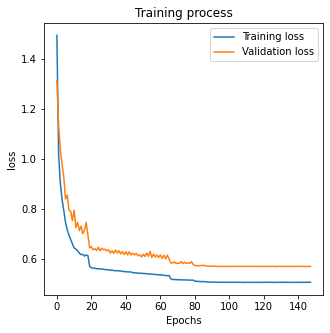

In [43]:
show_training_process(history=model_history, metric_name='loss',
                      figure_id=1)

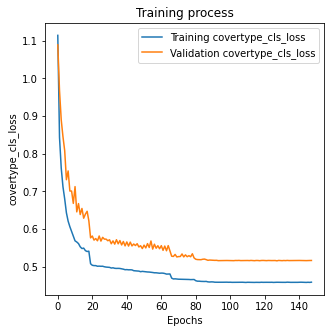

In [44]:
show_training_process(history=model_history, metric_name='covertype_cls_loss',
                      figure_id=2)

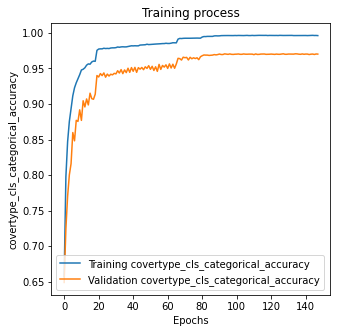

In [45]:
show_training_process(history=model_history,
                      metric_name='covertype_cls_categorical_accuracy',
                      figure_id=3)

In [46]:
del trainset_gen, validset_gen

In [47]:
del X_train, y_train

In [48]:
del trainable_nn

In [49]:
gc.collect()

10653

In [50]:
valid_probas = predict_proba(
    X=X_valid, encoder=encoding_nn, classifier=classification_nn,
    n_samples=1, batch_size=MINIBATCH_SIZE_FOR_INFERENCE
)

  0%|          | 0/863 [00:00<?, ?it/s]

In [51]:
print(classification_report(y_true=y_valid, y_pred=np.argmax(valid_probas, axis=1),
                            digits=4))

              precision    recall  f1-score   support

           0     0.9671    0.9720    0.9695     10063
           1     0.9776    0.9711    0.9743     13457
           2     0.9717    0.9711    0.9714      1698
           3     0.8963    0.9202    0.9081       451
           4     0.9448    0.9552    0.9500       825
           5     0.9667    0.9825    0.9745       974
           6     0.8797    0.8931    0.8864       131

    accuracy                         0.9701     27599
   macro avg     0.9434    0.9522    0.9477     27599
weighted avg     0.9702    0.9701    0.9702     27599



In [52]:
test_probas = predict_proba(
    X=X_test, encoder=encoding_nn, classifier=classification_nn,
    n_samples=1, batch_size=MINIBATCH_SIZE_FOR_INFERENCE
)

  0%|          | 0/908 [00:00<?, ?it/s]

In [53]:
print(classification_report(y_true=y_test, y_pred=np.argmax(test_probas, axis=1),
                            digits=4))

              precision    recall  f1-score   support

           0     0.9719    0.9712    0.9716     10592
           1     0.9779    0.9735    0.9757     14165
           2     0.9640    0.9726    0.9683      1788
           3     0.8941    0.9242    0.9089       475
           4     0.9357    0.9562    0.9459       868
           5     0.9582    0.9825    0.9702      1026
           6     0.9167    0.8832    0.8996       137

    accuracy                         0.9712     29051
   macro avg     0.9455    0.9519    0.9486     29051
weighted avg     0.9712    0.9712    0.9712     29051



In [54]:
test_probas = predict_proba(
    X=X_test, encoder=encoding_nn, classifier=classification_nn,
    n_samples=10, batch_size=MINIBATCH_SIZE_FOR_INFERENCE
)

  0%|          | 0/908 [00:00<?, ?it/s]

In [55]:
print(classification_report(y_true=y_test, y_pred=np.argmax(test_probas, axis=1),
                            digits=4))

              precision    recall  f1-score   support

           0     0.9724    0.9715    0.9719     10592
           1     0.9783    0.9735    0.9759     14165
           2     0.9635    0.9732    0.9683      1788
           3     0.8887    0.9242    0.9061       475
           4     0.9358    0.9574    0.9465       868
           5     0.9573    0.9825    0.9697      1026
           6     0.9167    0.8832    0.8996       137

    accuracy                         0.9714     29051
   macro avg     0.9447    0.9522    0.9483     29051
weighted avg     0.9715    0.9714    0.9714     29051



In [56]:
test_probas = predict_proba(
    X=X_test, encoder=encoding_nn, classifier=classification_nn,
    n_samples=100, batch_size=MINIBATCH_SIZE_FOR_INFERENCE
)

  0%|          | 0/908 [00:00<?, ?it/s]

In [57]:
print(classification_report(y_true=y_test, y_pred=np.argmax(test_probas, axis=1),
                            digits=4))

              precision    recall  f1-score   support

           0     0.9720    0.9710    0.9715     10592
           1     0.9779    0.9732    0.9756     14165
           2     0.9635    0.9732    0.9683      1788
           3     0.8887    0.9242    0.9061       475
           4     0.9358    0.9574    0.9465       868
           5     0.9582    0.9825    0.9702      1026
           6     0.9167    0.8832    0.8996       137

    accuracy                         0.9711     29051
   macro avg     0.9447    0.9521    0.9482     29051
weighted avg     0.9712    0.9711    0.9711     29051

